In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

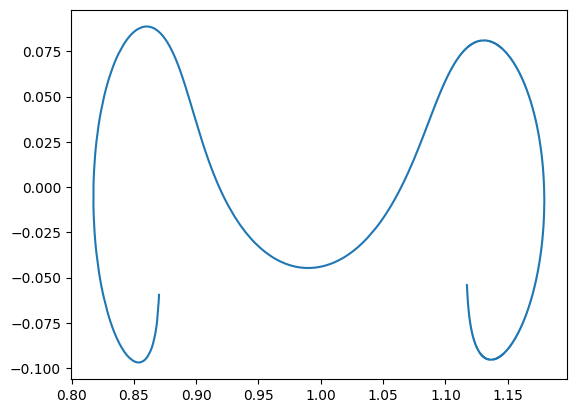

In [2]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [3]:
# three body problem env
import gym
from gym import spaces
import numpy as np

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        a_x = action[0]
        a_y = action[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y

        x = x + xdot*self.dt
        y = y + ydot*self.dt
        
        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        reward = 1 - np.linalg.norm(self.position - self.trajectory[self.steps], axis=0)
        done = self.steps >= self.max_steps
        if abs(self.position - self.trajectory[-1]).sum() < 0.05:
            done = True
            reward = 1000
        if self.steps > 1000:
            done = True
            reward = -1000
        if np.linalg.norm(self.state) > 2:
            done = True
            reward = -1000

        return np.array([1000, 1000, 1000, 1000])*self.state, reward, done, np.array([1000, 1000, 1000, 1000])*self.position

    def position2state(self):
        # find nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
    
    def reset(self):
        self.position = self.trajectory[0]   
        self.steps = 0
        self.position2state()
        return np.array([1000, 1000, 1000, 1000])*self.state
    
    def render(self):
        pass

    def close(self):
        pass

    



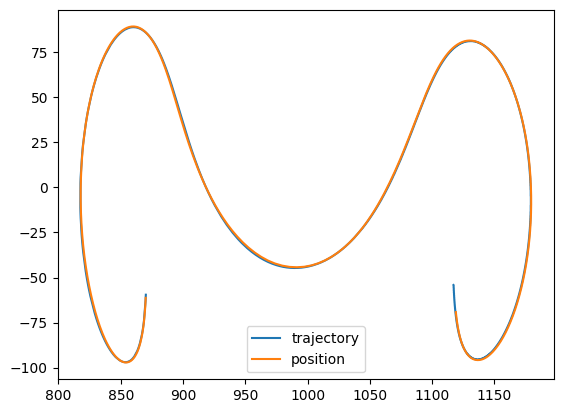

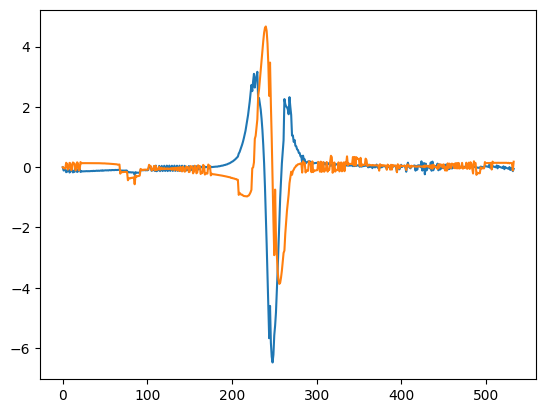

In [4]:
env = three_body_env(trajectory)
env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = -120 * env.state[2:] - 70 * env.state[:2]
    # print(action)
    action_array.append(10*action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(1000*trajectory[:,0], 1000*trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)


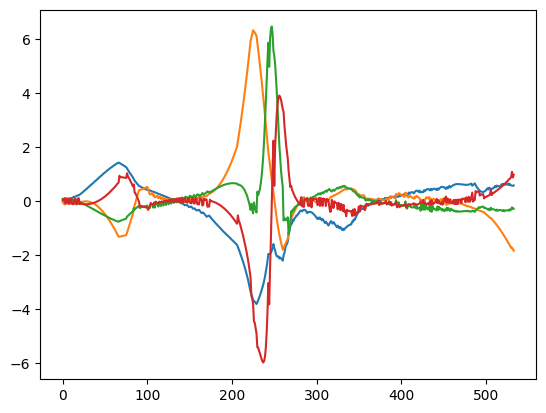

In [5]:
plt.plot(state_array)

/var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T/ipykernel_86187/824972056.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  input_data = torch.tensor(state_array, dtype=torch.float32)


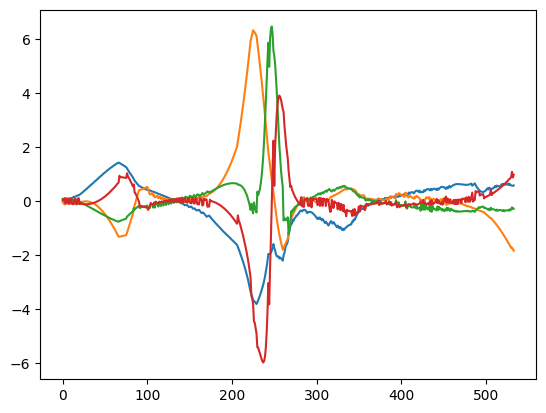

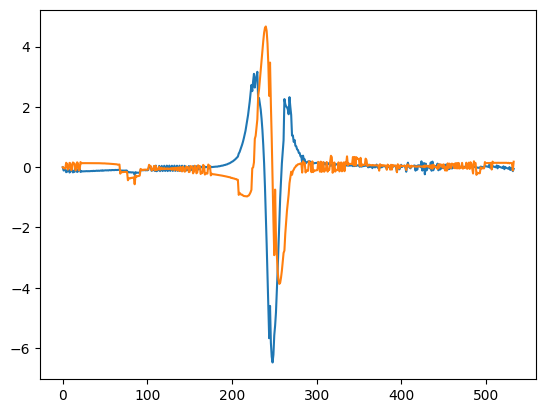

In [6]:
# pytorch NN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(4, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 2)

        self.max_action = 10

    def forward(self, state):
        a = F.tanh(self.l1(state))
        a = F.tanh(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))
    
        

# Create the network
net = Net()

# Define a Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=3e-5)


# Convert your input and output data to PyTorch tensors
input_data = torch.tensor(state_array, dtype=torch.float32)
output_data = torch.tensor(action_array, dtype=torch.float32)

# plt input
plt.plot(input_data)
plt.show()
plt.plot(output_data)
plt.show()

In [7]:
# Train the network
for epoch in range(10000):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(input_data)
    loss = criterion(outputs, output_data)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/10000], Loss: {loss.item():.6f}')

print('Finished Training')

# save Neural Network
torch.save(net.state_dict(), "actor")



Epoch [1/10000], Loss: 3.115823
Epoch [101/10000], Loss: 0.450267
Epoch [201/10000], Loss: 0.265686
Epoch [301/10000], Loss: 0.186688
Epoch [401/10000], Loss: 0.143931
Epoch [501/10000], Loss: 0.118668
Epoch [601/10000], Loss: 0.102931
Epoch [701/10000], Loss: 0.092710
Epoch [801/10000], Loss: 0.085819
Epoch [901/10000], Loss: 0.081004
Epoch [1001/10000], Loss: 0.077522
Epoch [1101/10000], Loss: 0.074917
Epoch [1201/10000], Loss: 0.072901
Epoch [1301/10000], Loss: 0.071292
Epoch [1401/10000], Loss: 0.069967
Epoch [1501/10000], Loss: 0.068845
Epoch [1601/10000], Loss: 0.067873
Epoch [1701/10000], Loss: 0.067012
Epoch [1801/10000], Loss: 0.066235
Epoch [1901/10000], Loss: 0.065524
Epoch [2001/10000], Loss: 0.064865
Epoch [2101/10000], Loss: 0.064249
Epoch [2201/10000], Loss: 0.063668
Epoch [2301/10000], Loss: 0.063116
Epoch [2401/10000], Loss: 0.062591
Epoch [2501/10000], Loss: 0.062087
Epoch [2601/10000], Loss: 0.061604
Epoch [2701/10000], Loss: 0.061138
Epoch [2801/10000], Loss: 0.0606

In [8]:
# load 
net = Net()
net.load_state_dict(torch.load("actor"))

<All keys matched successfully>

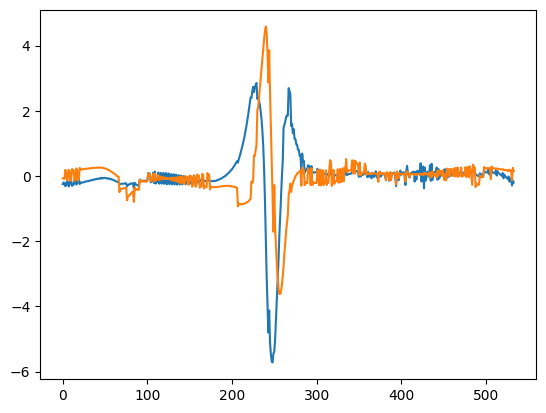

In [9]:
# predict
action_predict = net(input_data)
plt.plot(action_predict.detach().numpy())

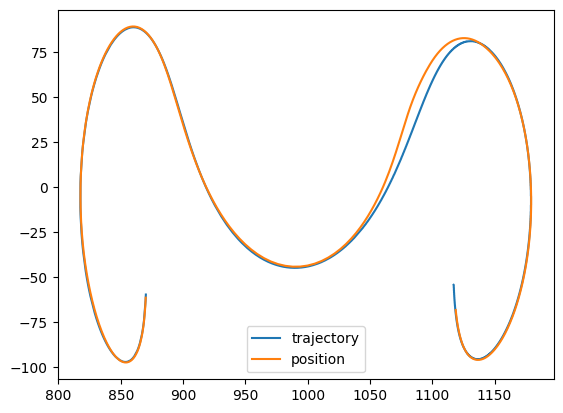

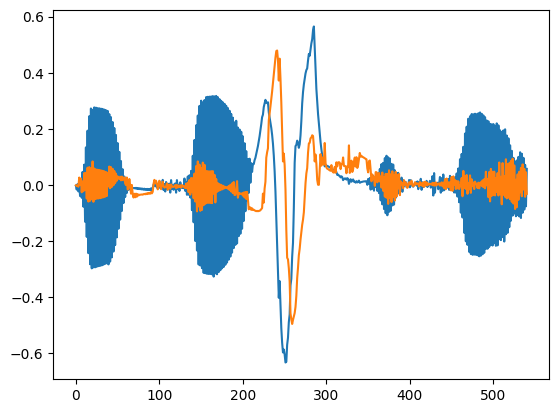

In [10]:
env = three_body_env(trajectory)
env.reset()
# save position
position_array = []
action_array = []
state_array = []

# using loaded Guidance
for i in range(600):
    input_data = torch.tensor(1000*env.state, dtype=torch.float32)
    action = net(input_data)
    action /= 10
    
    # print(action)
    action_array.append(action.detach().numpy())
    state, reward, done, position = env.step(action.detach().numpy())
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(1000*trajectory[:,0], 1000*trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legend
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)